In [1]:
import glob

# import seaborn as sns
# import warnings
import itertools
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
# warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.auto import tqdm
from IPython.display import display

In [2]:
import pathlib

In [3]:
colordict = {
    "GasCCS": "#b20101",
    "Gas": "#d35050",
    "HydroRes": "#08ad97",
    "HydroRoR": "#4adbc8",
    "OnWind": "#235ebc",
    "Solar": "#f9d002",
    "Import": "#8a1caf",
    "Windoffshore": "#6895dd",
    "Lion": "#baf238",
    "PumpedHydro": "#51dbcc",
    "NuclearEPR":"red",
    "Windoffshorefloating":"#74c6f2"
}

In [4]:
compressionfileending = ".zstd"
compressiondict = {"method": "zstd", "level": 19, "threads": -1}

In [5]:
resultspath = pathlib.Path("/cluster/work/projects/ec85/EFF/")

In [6]:
def modelstatus(modelpath):
    logfile = modelpath / "highres2.log"
    gamsfile = modelpath / "results.gdx"
    database = modelpath / "results.db"

    if logfile.is_file() and gamsfile.is_file() and database.is_file():
        with open(logfile) as logfile:
            if "Optimal solution found" in logfile.read():
                return "optimal"
            else:
                return "exists"
    else:
        return "missing"

# Reading files


In [7]:
Participatory_scenarios = pd.read_csv(resultspath / "scenarios.csv", sep="\t", keep_default_na=False, index_col=0)
Participatory_scenarios

,weatheryears,demandyears,spatials,trans,import_xxx,varnewpcapQ,corines_solar,corines_onshore,Nibios_solar,Nibios_onwind,fylke_techs,cutoffs_solar,cutoffs_onwind,cutoffs_offwind
0,2010,2030,grid,DefaultYes,0,OPT,CSD,CWD,NSD,NWD,fylketechD,0.09,0.15,0.2
1,2010,2030,grid,DefaultYes,0,OPT,CSD,CWD,NSD,NWD,fylketechC,0.09,0.15,0.2
2,2010,2030,grid,DefaultYes,0,OPT,CSD,CWDH,NSD,NWD,fylketechD,0.09,0.15,0.2
3,2010,2030,grid,DefaultYes,0,OPT,CSD,CWDH,NSD,NWD,fylketechC,0.09,0.15,0.2
4,2010,2030,grid,DefaultYes,0,OPT,CSD,CWDHA,NSD,NWD,fylketechD,0.09,0.15,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2010,2050,grid,LOWOH,10,QS1,CSD,CWDH,NSD,NWD,fylketechC,0.09,0.15,0.2
380,2010,2050,grid,LOWOH,10,QS1,CSD,CWDHA,NSD,NWD,fylketechD,0.09,0.15,0.2
381,2010,2050,grid,LOWOH,10,QS1,CSD,CWDHA,NSD,NWD,fylketechC,0.09,0.15,0.2
382,2010,2050,grid,LOWOH,10,QS1,CSD,CWDHAF,NSD,NWD,fylketechD,0.09,0.15,0.2


In [8]:
#Wildcards unique elements
demandyears = list(Participatory_scenarios['demandyears'].unique())
trans_expand = list(Participatory_scenarios['trans'].unique())
Imp_export = list(Participatory_scenarios['import_xxx'].unique())
newcapacities = list(Participatory_scenarios['varnewpcapQ'].unique())
onshorelandscap = list(Participatory_scenarios['corines_onshore'].unique())
fylkesnewcaplimit = list(Participatory_scenarios['fylke_techs'].unique())

In [9]:
data = {
    'demandyears': demandyears,
    'trans_expand': trans_expand,
    'Imp_export': Imp_export,
    'newcapacities': newcapacities,
    'onshorelandscap': onshorelandscap,
    'fylkesnewcaplimit': fylkesnewcaplimit
}
wildcard_elements = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
wildcard_elements['demandyears'] = wildcard_elements['demandyears'].apply(lambda x: '{:.0f}'.format(x))
wildcard_elements

,demandyears,trans_expand,Imp_export,newcapacities,onshorelandscap,fylkesnewcaplimit
0,2030,DefaultYes,0,OPT,CWD,fylketechD
1,2050,DefaultNO,2,QS1,CWDH,fylketechC
2,nan,LOWOH,5,NaN,CWDHA,NaN
3,nan,NaN,10,NaN,CWDHAF,NaN


In [11]:
requested_scenarios = (
    pd.read_csv(
        resultspath / "scenarios.csv", sep="\t", keep_default_na=False, index_col=0
    )
    # .set_index("index")
    # .rename_axis(index={"index": ""})
    .assign(
        path=lambda df: (
            resultspath
            / "models"
            / df.weatheryears.astype(str)
            / (
                df.weatheryears.astype(str)
                + "_"
                + df.demandyears.astype(str)
                + "_"
                + df.spatials.astype(str)
                + "_"
                + df.trans.astype(str)
                + "_"
                + df.import_xxx.astype(str)
                + "_"
                + df.varnewpcapQ.astype(str)
                + "_"
                + df.corines_solar.astype(str)
                + "_"
                + df.corines_onshore.astype(str)
                + "_"
                + df.Nibios_solar.astype(str)
                + "_"
                + df.Nibios_onwind.astype(str)
                + "_"
                + df.fylke_techs.astype(str)
                + "_"
                + df.cutoffs_solar.astype(str)
                + "_"
                + df.cutoffs_onwind.astype(str)
                + "_"
                + df.cutoffs_offwind.astype(str)
            )
        ),
        status=lambda df: df.path.apply(modelstatus),
    )
)

# Did the scenarios solve optimally?
requested_scenarios.query("status == 'optimal'")

,weatheryears,demandyears,spatials,trans,import_xxx,varnewpcapQ,corines_solar,corines_onshore,Nibios_solar,Nibios_onwind,fylke_techs,cutoffs_solar,cutoffs_onwind,cutoffs_offwind,path,status
0,2010,2030,grid,DefaultYes,0,OPT,CSD,CWD,NSD,NWD,fylketechD,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
1,2010,2030,grid,DefaultYes,0,OPT,CSD,CWD,NSD,NWD,fylketechC,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
2,2010,2030,grid,DefaultYes,0,OPT,CSD,CWDH,NSD,NWD,fylketechD,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
4,2010,2030,grid,DefaultYes,0,OPT,CSD,CWDHA,NSD,NWD,fylketechD,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
5,2010,2030,grid,DefaultYes,0,OPT,CSD,CWDHA,NSD,NWD,fylketechC,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2010,2050,grid,LOWOH,0,QS1,CSD,CWDHA,NSD,NWD,fylketechC,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
343,2010,2050,grid,LOWOH,2,OPT,CSD,CWDHAF,NSD,NWD,fylketechC,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
356,2010,2050,grid,LOWOH,5,OPT,CSD,CWDHA,NSD,NWD,fylketechD,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal
360,2010,2050,grid,LOWOH,5,QS1,CSD,CWD,NSD,NWD,fylketechD,0.09,0.15,0.2,/cluster/work/projects/ec85/EFF/models/2010/20...,optimal


In [12]:
list(requested_scenarios['status'].unique())

['optimal', 'missing']

In [13]:
found_scenarios = list((resultspath / "models").rglob("results.db"))
Exempler_scenarios = found_scenarios[:10]

In [14]:
Base_scenario30 = Path('/cluster/work/projects/ec85/EFF/models/2010/' + 
                '2010_2030_grid_DefaultYes_0_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')
Base_scenario50 = Path('/cluster/work/projects/ec85/EFF/models/2010/' + 
                '2010_2050_grid_DefaultYes_0_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')

In [15]:
if Base_scenario30 in found_scenarios:
    print(f"{Base_scenario30} found in the list.")
if Base_scenario50 in found_scenarios:
    print(f"{Base_scenario50} found in the list.")

/cluster/work/projects/ec85/EFF/models/2010/2010_2030_grid_DefaultYes_0_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db found in the list.


In [16]:
def makenice(scenariolist, parameter):
    returnlist = []

    basicindexlist = [
        #"weatheryear",
        "demandyear",
        "transmission",
        "ImpExp",
        "varnewpcapQ",
        "corines_solar",
        "corines_onshore",
        "fylke_techs",
    ]
    
    if parameter == "cost":
        table = "scalarvariables"
        index = ["name"]
        newindex = ["variable"]
        extraindex = newindex + ["level_1"]
        value = "costs"
        types = {}
        tabletype = "multiple"

    if parameter == "cap":
        table = "var_tot_pcap"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "gencaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "cap_z":
        table = "var_tot_pcap_z"
        index = ["z","g"]
        newindex = ["zone","technology"]
        extraindex = newindex + ["level_2"]
        value = "gencap"
        types = {}
        tabletype = "multiple"    

    if parameter == "newcap":
        table = "var_new_pcap"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "gencapnew"
        types = {}
        tabletype = "multiple"

    if parameter == "gen":
        table = "var_gen"
        index = ["h", "z", "g"]
        newindex = ["hour", "zone", "technology"]
        extraindex = newindex + ["level_3"]
        value = "genamttot"
        types = {"hour": int}
        tabletype = "multiple"

    if parameter == "gentot":
        table = "o_gen_tot"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "genamttot"
        types = {}
        tabletype = "single"

    if parameter == "pgen":
        table = "var_pgen"
        index = ["h", "z"]
        newindex = ["hour", "zone"]
        extraindex = newindex + ["level_2"]
        value = "pgen"
        types = {"hour": int}
        tabletype = "multiple"

    if parameter == "pgenz":
        table = "o_pgen_tot_z"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex
        value = "pgen"
        types = {}
        tabletype = "single"

    if parameter == "demand":
        table = "demand"
        index = ["z", "h"]
        newindex = ["zone", "hour"]
        extraindex = newindex
        value = "demand"
        types = {"hour": int}
        tabletype = "single"

    if parameter == "area":
        table = "area"
        index = ["vre", "z", "r"]
        newindex = ["technology", "zone", "region"]
        extraindex = newindex
        value = "area"
        types = {}
        tabletype = "single"

    if parameter == "storage_pcap":
        table = "var_tot_store_pcap"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "storepcaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "storage_ecap":
        table = "var_tot_store_ecap"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "storeecaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "storage_gen_tot":
        table = "o_store_gen_all"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex
        value = "storegentot"
        types = {}
        tabletype = "single"

    if parameter == "vre_gen":
        table = "vre_gen"
        index = ["h", "vre", "r"]
        newindex = ["hour", "technology", "region"]
        extraindex = newindex
        value = "capfac"
        types = {}
        tabletype = "single"

    if parameter == "trans_cap":
        table = "var_trans_pcap"
        index = ["z", "z_alias"]
        newindex = ["Zone_1", "Zone_2"]
        extraindex = newindex + ["level_2"]
        value = "transpcap"
        types = {}
        tabletype = "multiple"    

    if parameter == "costsgencapex":
        table = "costs_gen_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgencapex"
        types = {}
        tabletype = "multiple"

    if parameter == "costsgenfom":
        table = "costs_gen_fom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgenfom"
        types = {}
        tabletype = "multiple"

    if parameter == "costsgenvarom":
        table = "costs_gen_varom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgenvarom"
        types = {}
        tabletype = "multiple"

    if parameter == "costsstorecapex":
        table = "costs_store_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsstorecapex"
        types = {}
        tabletype = "multiple"

    if parameter == "costsstorefom":
        table = "costs_store_fom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsstorefom"
        types = {}
        tabletype = "multiple"

    if parameter == "costsstorevarom":
        table = "costs_store_varom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsstorevarom"
        types = {}
        tabletype = "multiple"

    if parameter == "coststranscapex":
        table = "costs_trans_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "coststranscapex"
        types = {}
        tabletype = "multiple"

    if parameter == "coststransfom":
        table = "costs_trans_fom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "coststransfom"
        types = {}
        tabletype = "multiple"

    if parameter == "costspgen":
        table = "costs_pgen"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costspgen"
        types = {}
        tabletype = "multiple"

    if parameter == "limpcapz":
        table = "gen_lim_pcap_z"
        index = ["z", "g", "lt"]
        newindex = ["zone", "technology", "limittype"]
        extraindex = newindex
        value = "limpcapz"
        types = {}
        tabletype = "single"

    if parameter == "pargencapex":
        table = "gen_capex"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "pargencapex"
        types = {}
        tabletype = "single"

    if parameter == "pargenfom":
        table = "gen_fom"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "pargenfom"
        types = {}
        tabletype = "single"

    if parameter == "pargenvarom":
        table = "gen_varom"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "pargenvarom"
        types = {}
        tabletype = "single"

    # if parameter == "pcap:
    #    table = "var_
    
    indexlist = basicindexlist + extraindex
    indexdict = dict(zip(index, newindex))
    indexdict.update({0: value})
    for scenario in tqdm(scenariolist):
        scenarioname = str(scenario).split("/")[-2]
        year = str(scenario).split("/")[-3]
        #    scenarioname = str(scenario)[18:-11]
        scenarionamesplit = scenarioname.split("_")

        if parameter != "capacityfactor":
            con = sqlite3.connect(scenario)

        appendme = pd.read_sql_query(f"SELECT * from {table}", con)

        if tabletype == "multiple":
            appendme = appendme.set_index(index).stack().reset_index()

        appendme = (
            appendme.rename(columns=indexdict)
            .assign(
                #weatheryear=year,
                demandyear=scenarionamesplit[1],
                transmission=scenarionamesplit[3],
                ImpExp=scenarionamesplit[4],
                varnewpcapQ=scenarionamesplit[5],
                corines_solar=scenarionamesplit[6],
                corines_onshore=scenarionamesplit[7],
                fylke_techs=scenarionamesplit[10]
            )
            .astype(types)
            .set_index(indexlist)
            .sort_index()
        )
        returnlist.append(appendme)
        con.close()
    return pd.concat(returnlist)

In [17]:
len(found_scenarios)

72

In [18]:
cost = makenice(found_scenarios, "cost")

  0%|          | 0/72 [00:00<?, ?it/s]

In [19]:
cost

costs
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable level_1                
2030       DefaultNO    0      QS1         CSD           CWD             fylketechC  costs    level      8.397801e+03
                                                                                              lo       -1.000000e+100
                                                                                              marginal   0.000000e+00
                                                                                              up        1.000000e+100
2050       LOWOH        5      OPT         CSD           CWDHA           fylketechD  costs    level      6.372285e+03
...                                                                                                               ...
2030       DefaultYes   0      OPT         CSD           CWDHA           fylketechC  costs    up        1.000000e+100
2050       DefaultYes   0      OPT         CSD           CWDH            fylketechC  costs    level      1.128159e+04
                                                                                              lo       -1.000000e+100
                                                                                              marginal   0.000000e+00
                                                                                              up        1.000000e+100

[288 rows x 1 columns]

In [20]:
level_slice = (slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), 'level')

cost = cost.loc[level_slice]

In [21]:
cost

costs
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable              
2030       DefaultNO    0      QS1         CSD           CWD             fylketechC  costs      8397.801155
2050       LOWOH        5      OPT         CSD           CWDHA           fylketechD  costs      6372.284691
2030       DefaultNO    10     QS1         CSD           CWD             fylketechD  costs      4725.121125
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs      6516.962124
2030       LOWOH        0      QS1         CSD           CWDHA           fylketechD  costs      8055.275336
...                                                                                                     ...
           DefaultYes   0      QS1         CSD           CWDHA           fylketechC  costs     12786.199165
2050       DefaultYes   0      QS1         CSD           CWDHA           fylketechC  costs     12061.919153
2030       LOWOH        0      OPT         CSD           CWD             fylketechC  costs      8121.384101
           DefaultYes   0      OPT         CSD           CWDHA           fylketechC  costs     11001.269538
2050       DefaultYes   0      OPT         CSD           CWDH            fylketechC  costs     11281.592419

[72 rows x 1 columns]

In [22]:
cost.sort_values(by=['demandyear', 'transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs'])

costs
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable             
2030       DefaultNO    0      OPT         CSD           CWD             fylketechC  costs     8053.691161
                                                         CWDHA           fylketechC  costs     8149.920817
                               QS1         CSD           CWD             fylketechC  costs     8397.801155
                                                                         fylketechD  costs     7965.585795
                                                         CWDHA           fylketechC  costs     8432.428969
...                                                                                                    ...
2050       LOWOH        0      QS1         CSD           CWDHA           fylketechC  costs     9691.271272
                        2      OPT         CSD           CWDHAF          fylketechC  costs     8775.630668
                        5      OPT         CSD           CWDHA           fylketechD  costs     6372.284691
                               QS1         CSD           CWD             fylketechD  costs     6516.962124
                                                         CWDHAF          fylketechC  costs     7670.569780

[69 rows x 1 columns]

In [22]:
Base_scenario30

PosixPath('/cluster/work/projects/ec85/EFF/models/2010/2010_2030_grid_DefaultYes_0_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')

In [23]:
Base_scenario30_cost = cost.query(
                " demandyear in ['2030'] and"
                " transmission in ['DefaultYes'] and"
                " ImpExp in ['0'] and"
                " varnewpcapQ in ['OPT'] and "
                " corines_onshore in ['CWD'] and"
                " fylke_techs in ['fylketechD']"
)['costs'].values[0]
Base_scenario30_cost

8353.880444316588

In [24]:
cost['percent_change'] = cost.apply(
    lambda x: (x['costs'] - Base_scenario30_cost) / Base_scenario30_cost * 100 
    if x.name[0] == 2030 
    else (x['costs'] - Base_scenario30_cost) / Base_scenario30_cost * 100,    #use base_scenario50 here 
    axis=1)
cost

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2030       DefaultNO    0      QS1         CSD           CWD             fylketechC  costs      8397.801155   
2050       LOWOH        5      OPT         CSD           CWDHA           fylketechD  costs      6372.284691   
2030       DefaultNO    10     QS1         CSD           CWD             fylketechD  costs      4725.121125   
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs      6516.962124   
2030       LOWOH        0      QS1         CSD           CWDHA           fylketechD  costs      8055.275336   
...                                                                                                     ...   
           DefaultYes   0      QS1         CSD           CWDHA           fylketechC  costs     12786.199165   
2050       DefaultYes   0      QS1         CSD           CWDHA           fylketechC  costs     12061.919153   
2030       LOWOH        0      OPT         CSD           CWD             fylketechC  costs      8121.384101   
           DefaultYes   0      OPT         CSD           CWDHA           fylketechC  costs     11001.269538   
2050       DefaultYes   0      OPT         CSD           CWDH            fylketechC  costs     11281.592419   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       DefaultNO    0      QS1         CSD           CWD             fylketechC  costs           0.525752  
2050       LOWOH        5      OPT         CSD           CWDHA           fylketechD  costs         -23.720662  
2030       DefaultNO    10     QS1         CSD           CWD             fylketechD  costs         -43.438009  
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs         -21.988803  
2030       LOWOH        0      QS1         CSD           CWDHA           fylketechD  costs          -3.574448  
...                                                                                                       ...  
           DefaultYes   0      QS1         CSD           CWDHA           fylketechC  costs          53.057004  
2050       DefaultYes   0      QS1         CSD           CWDHA           fylketechC  costs          44.387021  
2030       LOWOH        0      OPT         CSD           CWD             fylketechC  costs          -2.783094  
           DefaultYes   0      OPT         CSD           CWDHA           fylketechC  costs          31.690531  
2050       DefaultYes   0      OPT         CSD           CWDH            fylketechC  costs          35.046132  

[72 rows x 2 columns]

In [25]:
#query string for sequential scenarios analysis with ImpExp = 5 (incremental changes from base scenario)
seq_query_string_5 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '5' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC')
"""
seq_query_string_5 = seq_query_string_5.replace('\n', ' ').strip()

In [26]:
#query string for sequential scenarios analysis with ImpExp = 10 (incremental changes from base scenario)
seq_query_string_10 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '10' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC')
"""
seq_query_string_10 = seq_query_string_10.replace('\n', ' ').strip()

In [27]:
#query string for independent scenario analysis with ImpExp ==5 (rest-to-Base approach)
Ind_query_string_5 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '5' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '5' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC')
"""
Ind_query_string_5 = Ind_query_string_5.replace('\n', ' ').strip()

In [28]:
#query string for independent scenario analysis with ImpExp ==5 (rest-to-Base approach)
Ind_query_string_10 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '0' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC')
"""
Ind_query_string_10 = Ind_query_string_10.replace('\n', ' ').strip()

In [29]:
cost_seq_pref_5 = (cost.query(seq_query_string_5)
                .sort_values(by=['demandyear', 'transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']))
cost_seq_pref_5

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                
2030       DefaultYes   0      OPT         CSD           CWD             fylketechD  costs     8353.880444   
           LOWOH        0      OPT         CSD           CWD             fylketechD  costs     7166.046592   
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs     6516.962124   
                                                         CWDHAF          fylketechC  costs     7670.569780   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       DefaultYes   0      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        0      OPT         CSD           CWD             fylketechD  costs         -14.218947  
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs         -21.988803  
                                                         CWDHAF          fylketechC  costs          -8.179560

In [99]:
cost_seq_pref_5['percent_change'].unstack()

variable                                                                                  costs
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs           
2030       DefaultYes   0      OPT         CSD           CWD             fylketechD    0.000000
           LOWOH        0      OPT         CSD           CWD             fylketechD  -14.218947
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  -21.988803
                                                         CWDHAF          fylketechC   -8.179560

In [104]:
cost_seq_pref_5.reset_index().set_index('demandyear').loc[['2030', '2050'], ['percent_change']]

,percent_change
demandyear,
2030,0.000000
2030,-14.218947
2050,-21.988803
2050,-8.179560


In [111]:
cost_seq_pref_5.reset_index().pivot(columns='demandyear', values='percent_change')

demandyear,2030,2050
0,0.000000,NaN
1,-14.218947,NaN
2,NaN,-21.988803
3,NaN,-8.179560


In [31]:
#example_plot = example_plot.sort_values(by='percent_change', ascending=False)

In [40]:
example_plot

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2030       DefaultNO    0      QS1         CSD           CWD             fylketechC  costs      8397.801155   
2050       LOWOH        5      OPT         CSD           CWDHA           fylketechD  costs      6372.284691   
2030       DefaultNO    10     QS1         CSD           CWD             fylketechD  costs      4725.121125   
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs      6516.962124   
2030       LOWOH        0      QS1         CSD           CWDHA           fylketechD  costs      8055.275336   
                                                         CWDH            fylketechD  costs      8039.759006   
           DefaultNO    2      OPT         CSD           CWDH            fylketechD  costs      5535.139503   
2050       DefaultNO    2      QS1         CSD           CWDHAF          fylketechC  costs      8671.227564   
                        0      QS1         CSD           CWDHAF          fylketechD  costs      9119.124250   
                                                         CWD             fylketechC  costs      9564.913092   
                               OPT         CSD           CWDH            fylketechD  costs      8088.007516   
           DefaultYes   0      QS1         CSD           CWD             fylketechC  costs     12031.800230   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       DefaultNO    0      QS1         CSD           CWD             fylketechC  costs           0.525752  
2050       LOWOH        5      OPT         CSD           CWDHA           fylketechD  costs         -23.720662  
2030       DefaultNO    10     QS1         CSD           CWD             fylketechD  costs         -43.438009  
2050       LOWOH        5      QS1         CSD           CWD             fylketechD  costs         -21.988803  
2030       LOWOH        0      QS1         CSD           CWDHA           fylketechD  costs          -3.574448  
                                                         CWDH            fylketechD  costs          -3.760186  
           DefaultNO    2      OPT         CSD           CWDH            fylketechD  costs         -33.741696  
2050       DefaultNO    2      QS1         CSD           CWDHAF          fylketechC  costs           3.798799  
                        0      QS1         CSD           CWDHAF          fylketechD  costs           9.160339  
                                                         CWD             fylketechC  costs          14.496648  
                               OPT         CSD           CWDH            fylketechD  costs          -3.182628  
           DefaultYes   0      QS1         CSD           CWD             fylketechC  costs          44.026483

<AxesSubplot: xlabel='demandyear'>

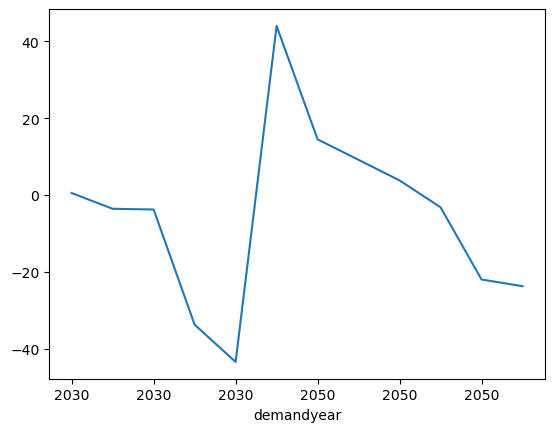

In [38]:
x_labels = ['OPT', '+landscape', '+technology', '+county', '+trading', '+transmission']
example_plot.query()

#example_plot.reset_index().set_index('demandyear').sort_values(by='demandyear')['percent_change'].plot()

In [ ]:
def barplot(inputdf, logx=False):
    return (
        inputdf.groupby(["year", "Spatial", "participation", "V2G"]).sum()
        # .reset_index()
        # .assign(
        #    name=lambda df: df.year.astype(str)
        #    + "_"
        #    + df.Nature
        #    + "_"
        #    + df.Fauna
        #    + "_"
        #    + df.Sami
        #    + "_"
        #    + df.Neigh
        #    + "_"
        #    + df.Solar
        #    + "_"
        #    + df.Spatial
        #    + "_"
        #    + df.Cutoff
        # )
        # .set_index("name")
        .sort_index()
        # .sort_values(by="value")
        # .loc[:, "value"]
        .plot.barh(figsize=(10, 15), logx=logx)
    )

In [ ]:
sqlite_list = found_scenarios

In [ ]:
# sqlite_list = requested_scenarios.query("status != 'optimal'").path / "results.db"

In [ ]:
sqlite_list = requested_scenarios.query("status == 'optimal'").path / "results.db"

In [ ]:
groupbycountry = [
    "year",
    "Spatial",
    # "Cutoff",
]

# Demand


In [ ]:
# How much demand do we see in each scenario?
dem = makenice(sqlite_list, "demand")

In [ ]:
dem

In [ ]:
barplot(dem)

In [ ]:
barplot(dem)

In [ ]:
dem.groupby(groupbycountry).sum().groupby("year").first()

# Area

This is not actually area but maximum installable capacity in GW.


In [ ]:
# How to deal with existing wind and the areas that it covers? atlite vs gams...
# How much area is available per scenario for onshore wind?
area = makenice(sqlite_list, "area")

In [ ]:
area

In [ ]:
(
    area.groupby(
        [
            "year",
            "Nature",
            "Fauna",
            "Sami",
            "Neigh",
            "Solar",
            "Spatial",
            "technology",
            "Cutoff",
        ]
    )
    .sum()
    .query("technology == 'Windonshore'")
    .sort_values("value")
)

In [ ]:
area

In [ ]:
# barplot
(
    area.groupby(
        [
            "year",
            "Nature",
            "Fauna",
            "Sami",
            "Neigh",
            "Solar",
            "Spatial",
            "Cutoff",
            "technology",
        ]
    ).sum()
    # .query("technology == 'Windonshore'")
)

# Penalty generation


In [ ]:
# How much penalty generation per scenario?
pgenz = makenice(sqlite_list, "pgenz")

In [ ]:
pgenz  # .plot()
# TODO check if installed capacity is real installed capacity, fix for regional, ignore others
# TODO no offshore

In [ ]:
pgenz  # .plot()
# TODO check if installed capacity is real installed capacity, fix for regional, ignore others
# TODO no offshore

In [ ]:
# TODO check if we have a fixed 30GW scenario as well

In [ ]:
pgenz.groupby(
    ["year","Spatial"]
).sum().sort_values("value")

In [ ]:
barplot(pgenz,logx=True)

In [ ]:
barplot(pgenz)

In [ ]:
barplot(pgenz)
# scale by value of lost load and put on log scale
# integrate pgen with o gen tot
# can offshore be built?

In [ ]:
# Scenariooverview (specify one scenario and get info like):
## Pgen? Imports? Imports max out (when)?

# Generation


In [ ]:
gentot = makenice(sqlite_list, "gentot")
# https://www.duo.uio.no/bitstream/handle/10852/80496/ieee_2020.pdf?sequence=2&isAllowed=y

In [ ]:
gentot

In [ ]:
scale = 1
(
    gentot
    # .query(
    #    "year == '2010'"
    #    #   " & Solar == 'Low'"
    #    "& ((Neigh == 'High' and Solar == 'High') or (Neigh == 'None' and Solar == 'Low'))"
    # )
    .unstack()
    .loc[:, "value"]
    .loc[:, ["Import", "Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    # .sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        #stacked=True,
        title="Norwegian electrictiy generation without Hydro 2030",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

# why does it not max out imports is it because the imports only have some access points and pgen can come in all the time and everywher
# change imports to average values of the past
# maybe limit imports to max of historical imports? inspiration from the UK paper. give a paragraph of explanation as to why.
# we can not keep it because there is no realistic scenario for why we would not import at reasonable prices
# TODO add battery in this plot

In [ ]:
scale = 1
(
    gentot
    # .query(
    #    "year == '2010'"
    #    #   " & Solar == 'Low'"
    #    "& ((Neigh == 'High' and Solar == 'High') or (Neigh == 'None' and Solar == 'Low'))"
    # )
    .unstack()
    .loc[:, "value"]
    #.loc[:, ["Import", "Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    # .sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        #stacked=True,
        title="Norwegian electrictiy generation without Hydro 2030",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

# why does it not max out imports is it because the imports only have some access points and pgen can come in all the time and everywher
# change imports to average values of the past
# maybe limit imports to max of historical imports? inspiration from the UK paper. give a paragraph of explanation as to why.
# we can not keep it because there is no realistic scenario for why we would not import at reasonable prices
# TODO add battery in this plot

In [ ]:
scale = 1
(
    gentot
    # .query(
    #    "year == '2010'"
    #    #   " & Solar == 'Low'"
    #    "& ((Neigh == 'High' and Solar == 'High') or (Neigh == 'None' and Solar == 'Low'))"
    # )
    .unstack()
    .loc[:, "value"]
    #.loc[:, ["Import", "Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    # .sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        #stacked=True,
        title="Norwegian electrictiy generation without Hydro 2030",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

# why does it not max out imports is it because the imports only have some access points and pgen can come in all the time and everywher
# change imports to average values of the past
# maybe limit imports to max of historical imports? inspiration from the UK paper. give a paragraph of explanation as to why.
# we can not keep it because there is no realistic scenario for why we would not import at reasonable prices
# TODO add battery in this plot

In [ ]:
# Is offshore wind forced?
makenice(sqlite_list, "limpcapz").unstack().unstack().unstack().iloc[
    0, :
].to_frame().unstack().query("technology == 'Windoffshore'").T

In [ ]:
# How much import per scenario?
barplot(gentot.query("technology == 'Import'"))

In [ ]:
# how much electricity in the Finse paper is generated from hydro power in the 2010 results
gentot.query("year == '2010' and technology.str.contains('Hydro')").unstack().plot.barh(
    figsize=(10, 10), stacked=True
)

In [ ]:
# How much onshore wind in each regional scenario?
gentot.query("technology == 'Windonshore'").sort_index().plot.barh(
    figsize=(21.533 / scale, 12.582 / scale)
)  # .sort_values("value")

In [ ]:
storage_gen_tot = makenice(sqlite_list, "storage_gen_tot")

## Generation Hourly


In [ ]:
# Hourly generation per zone and technology
gen = makenice(sqlite_list, "gen")

In [ ]:
gen

In [ ]:
gen.to_csv(
    "gen.csv" + compressionfileineding, compression=compressiondict
)  # .to_parquet("costs.parquet")

In [ ]:
# check if variable exists, only if not, run sql

# Storage


In [ ]:
# https://www.elvia.no/drift-og-vedlikehold/utbygginger-og-prosjekter/vi-skal-styrke-stromforsyningen-sor-i-oslo-liasen/
# https://eeg.tuwien.ac.at/conference/iaee2017/files/paper/623_Ovaere_fullpaper_2017-04-01_17-14.pdf table 3

In [ ]:
storetot = makenice(sqlite_list, "storage_pcap")

In [ ]:
storetot

In [ ]:
(
    storetot.query("level_1 == 'level'")
    .droplevel("level_1")
    .unstack()
    .loc[:, "storepcaptot"]
    # .loc[:,["Import","Solar","Windoffshore","Windonshore"]]
    # .sort_values(["Windonshore"])
    # .rename(columns={"Windonshore":"OnWind"})
    .plot.barh(
        stacked=True,
        title="Norwegian electrictiy storage power capcacity 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        # color=colordict
    )
)

# scatterplot pv correlation with battery

In [ ]:
storetot

In [ ]:
(
    pd.concat([gentot, storage_gen_tot.rename(columns={"storecaptot": "value"})])
    .query("year == '2010' and Spatial == 'grid'")
    .unstack()
    .loc[:, "value"]
    .rename(columns={"Li-ion-8": "Lion", "Windonshore": "OnWind"})
    .drop(columns=["HydroRes", "HydroRoR"])
    .plot.barh(
        stacked=True,
        title="Electricity generation in 2030 in Norway without hydropower because that is almost constant",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)  #
# Include penalty generation

In [ ]:
gentot.concat(storetot)

# Costs


In [ ]:
# How expensive is each scenario?
costs = makenice(sqlite_list, "cost")

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False)

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False)

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs

In [ ]:
barplot(costs.query('level_1 == "level"').rename(columns={"costs": "value"}))

In [ ]:
costs.query(
    "level_1 == 'level' and year == '2010'"
    "and Spatial == 'grid'"
    "and Neigh != 'High'"
).unstack(["Solar"]).plot.barh(subplots=True, figsize=(15, 15))

In [ ]:
# 4.1 General cost overview
barplot(
    costs.query(
        "level_1 == 'level' and Spatial == 'grid' and Solar != 'High' and Neigh != 'High'"
    ),
    True,
)

In [ ]:
#

barplot(
    costs.query(
        #    'level_1 == "level" and year == "2010" and Cutoff == "0.15" and Neigh != "High"'
        'level_1 == "level"'
        #' and Neigh != "High"'
        'and Spatial == "grid" and year == "2010" and Solar == "High"'
    )
    .assign(relcost=lambda df: (df.costs / df.costs.min()).mul(100) - 100)
    .loc[:, ["relcost"]]
    .rename(
        columns={"relcost": "Relative cost increase compared to cheapest scenario [%]"}
    ),
    True,
)
# plt.xlim(1,1.2)
# stacked bars for load shedding

# Maybe reduce the number of bars and take Figure 4 from the low carbon paper as in inspiration?
# Create this with more info from the distribution of costs from the bottom
# Two panels on costs

In [ ]:
(
    costs.sort_index()
    .reset_index()
    .assign(
        name=lambda df: df.year.astype(str)
        + "_"
        + df.Nature
        + "_"
        + df.Fauna
        + "_"
        + df.Sami
        + "_"
        + df.Neigh
        + "_"
        + df.Solar
        + "_"
        + df.Spatial
    )
    .query('level_1 == "level"')
    .drop(columns=["variable", "level_1"])
    .set_index("name")
    # .sort_values(by="costs")
    .loc[:, "costs"]
    .plot.barh(figsize=(10, 15))
)

In [ ]:
df_costs.loc[(slice(None), "var_system_costs", slice(None))]

# Capacity


## Generator power capacity


### Total


In [ ]:
caps.index.levels

In [ ]:
level_to_change = 2
caps.index.set_levels(caps.index.levels[level_to_change].astype(int), level=level_to_change)

In [ ]:
# How much capacity per scenario?
caps = makenice(sqlite_list, "cap")
caps.index = caps.index.set_levels(caps.index.levels[level_to_change].astype(int), level=level_to_change)

In [ ]:
caps.query("level_1=='level'")

In [ ]:
caps.query("level_1=='level'&technology=='Windoffshore'")

In [ ]:
caps.query("level_1=='level'&technology=='NuclearEPR'")

In [ ]:
scale = 1
(
    caps.query(
        "level_1 == 'level'"
        ## "& year == '2010'"
        ## "& ((Neigh == 'High' and Solar == 'Low') or (Neigh == 'None' and Solar == 'Low'))"
        ## " & Solar == 'Low'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore", "Windoffshorefloating"]]
    .sort_index()
    ###.sort_values(["Windonshore"])
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    # .query("year == '2010'")  # and ( Neigh == 'High' or Neigh == 'None') ")
    # .drop(columns=[
    #    "HydroRes",
    #    "HydroRoR",
    #    "Import"
    # ])
    # .loc[:,[
    #     #"OnWind",
    #     #"Solar"]
    # ]]
    .plot.barh(
        #stacked=True,
        title="Norwegian optimal installed electrictiy generation capacity without hydro and imports because they are fixed 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

In [ ]:
scale = 1
(
    caps.query(
        "level_1 == 'level'"
        ## "& year == '2010'"
        ## "& ((Neigh == 'High' and Solar == 'Low') or (Neigh == 'None' and Solar == 'Low'))"
        ## " & Solar == 'Low'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    ###.sort_values(["Windonshore"])
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    # .query("year == '2010'")  # and ( Neigh == 'High' or Neigh == 'None') ")
    # .drop(columns=[
    #    "HydroRes",
    #    "HydroRoR",
    #    "Import"
    # ])
    # .loc[:,[
    #     #"OnWind",
    #     #"Solar"]
    # ]]
    .plot.barh(
        #stacked=True,
        title="Norwegian optimal installed electrictiy generation capacity without hydro and imports because they are fixed 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

In [ ]:
scale = 1
(
    caps.query(
        "level_1 == 'level'"
        ## "& year == '2010'"
        ## "& ((Neigh == 'High' and Solar == 'Low') or (Neigh == 'None' and Solar == 'Low'))"
        ## " & Solar == 'Low'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    ###.sort_values(["Windonshore"])
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    # .query("year == '2010'")  # and ( Neigh == 'High' or Neigh == 'None') ")
    # .drop(columns=[
    #    "HydroRes",
    #    "HydroRoR",
    #    "Import"
    # ])
    # .loc[:,[
    #     #"OnWind",
    #     #"Solar"]
    # ]]
    .plot.barh(
        #stacked=True,
        title="Norwegian optimal installed electrictiy generation capacity without hydro and imports because they are fixed 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

### New


In [ ]:
# TODO: What percentage of total land area are we using?
caps

In [ ]:
# How much new capacity per scenario?
newcaps = makenice(sqlite_list, "newcap")

In [ ]:
newcaps

In [ ]:
(
    newcaps.reset_index()
    #.assign(
    #    name=lambda df: df.year.astype(str)
    #    + "_"
    #    + df.Nature
    #    + "_"
    #    + df.Fauna
    #    + "_"
    #    + df.Sami
    #    + "_"
    #    + df.Neigh
    #    + "_"
    #    + df.Solar
    #    + "_"
    #    + df.Spatial
    #)
    #.query('level_1 == "level"')
    # .drop(columns=["level_1"])
    # .set_index("name")
    # .sort_values(by="gencapnew")
    # .loc[:, "gencapnew"]
    # .plot.barh(figsize=(10, 15))
)

## Storage capacity


### Storage Energy Capacity


In [ ]:
# see if this can be done with list comprehension
e_cap_dfs = []
for scenario in tqdm(sqlite_list):
    if pathlib.Path(scenario).is_file():
        con = sqlite3.connect(scenario)
        e_cap_dfs.append(
            pd.read_sql_query("SELECT * from var_tot_store_ecap", con)
            # .set_index("g")
            # .rename(
            #    {
            #        "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            #        "NaturalgasOCGTnew": "Gas",
            #        "Windonshore": "OnWind",
            #    },
            #    axis="index",
            # )
            # .loc[:, ["level"]]
            # .rename_axis(index={"g": "Technology"})
            # .rename(columns={"level": "installed_capacity_GW"})
            # .assign(scenario=scenario[64:-11])
            # .reset_index()
            # .set_index(["scenario", "Technology"])
            # .sort_index()
        )
        con.close()
e_cap2 = pd.concat(e_cap_dfs)
del e_cap_dfs

In [ ]:
e_cap2

### Storage power capacity


In [ ]:
storage_pcap = makenice(sqlite_list, "storage_pcap")

In [ ]:
storage_pcap

In [ ]:
# FX the RoR
# Dispatch (when is the pgen used)
# aggregate to national dispatch, plot demand and pgen and see when pgen happens
# random 500 hours

In [ ]:
scale = 1
(
    p_cap2.reindex(
        p_cap2.groupby(["scenario"]).sum().sort_index()
        # .sort_values("installed_capacity_GW")
        .index.to_list(),
        level=0,
    )
    .unstack()
    .loc[:, "installed_capacity_GW"]
    .plot.barh(
        stacked=True,
        title="Norwegian installed generation capacity 2030 (Weather year/Nature_Fauna_Sami_Neighbours_Solar)",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)
# plt.savefig("output.svg", bbox_inches="tight")
# fig = plot.get_figure()
# fig.savefig("output.svg")

# is there a cutoff now?
# drop the grid.

In [ ]:
(p_cap2.unstack().loc[:, "installed_capacity_GW"])

In [ ]:
# get rid of the left three bars
scale = 1
(
    p_cap2
    # .reindex(
    #    p_cap2.groupby(["scenario"])
    #    .sum()
    #    #.sort_index()
    #    .sort_values("installed_capacity_GW")
    #    .index.to_list(),
    #    level=0,
    # )
    .unstack()
    .loc[:, "installed_capacity_GW"]
    .loc[:, ["Gas", "GasCCS", "OnWind", "Solar", "Windoffshore"]]
    .plot.bar(
        stacked=True,
        title="Norwegian installed generation capacity (without hydro) 2030 (Weather year/Nature_Fauna_Sami_Neighbours_Solar)",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

In [ ]:
# build a small scenario table
# Why no batteries? Costs?

In [ ]:
# Have a (REGIONAL) run with no wind at all for non extreme ones.

In [ ]:
# Existing wind does not produce cause it has no area
# One of them could be the baseline (none scenario/todays system)

In [ ]:
# Why does Hydro RoR change?
# Why is there still wind in the extreme cases?
# What is the storage situation like?

In [ ]:
p_cap2.assign(scen=lambda df: df.index.get_level_values(0).str[64:-11])

In [ ]:
scen

In [ ]:
pd.read_parquet(
    "/cluster/work/projects/ec85/joint-wind/model-aggregated/results/models/1995/corrected_wind_capacity_factors_1995.parquet"
)

## Total generation capacity


In [ ]:
pcaptot = pd.concat(
    [
        storage_pcap.rename(columns={"storepcaptot": "pcaptot"}),
        caps.rename(columns={"gencaptot": "pcaptot"}),
    ],
    axis=0,
).sort_index()

In [ ]:
(
    pcaptot.query(
        "level_1 == 'level' and year == '2010' and Spatial== 'grid' and Solar == 'High'"
    )
    .droplevel(["level_1", "year", "Spatial", "Solar", "Cutoff"])
    .unstack()
    .loc[:, "pcaptot"]
    .rename(
        columns={
            "Li-ion-8": "Lion",
            "Windonshore": "OnWind",
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        }
    )
    .plot.barh(
        stacked=True,
        title="Norwegian installed generation capacity 2030 (Weather year/Nature_Fauna_Sami_Neighbours_Solar)",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
        # subplots=True
    )
)
# Go into the appendix with the "real optimum" show the "realistic optimum" in the main text

# Do delta plots going up and down plot 4 applied energy

In [ ]:
# How much new transmission is there?

# Capacity Factors


In [ ]:
import connectorx as cx

db_path = str(sqlite_list[0])  # path to your SQLite database
conn = "sqlite://" + db_path  # connection token
# query = 'SELECT h,vre,r,AVG(value) FROM vre_gen GROUP BY h'            # query string
query = "SELECT vre,r,AVG(value) FROM vre_gen WHERE vre='Windoffshore' GROUP BY vre,r;"
cx.read_sql(conn, query)  # read data from SQLite

In [ ]:
sql_conn = sqlite3.connect(sqlite_list[0], timeout=60)
connectorx.read_sql(sql_conn, "SELECT * FROM vre_gen")

In [ ]:
capfacs = makenice(sqlite_list, "vre_gen")

In [ ]:
for scenario in tqdm(scenariolist):
        scenarioname = str(scenario).split("/")[-2]
        year = str(scenario).split("/")[-3]
        #    scenarioname = str(scenario)[18:-11]
        scenarionamesplit = scenarioname.split("_")

        if parameter != "capacityfactor":
            con = sqlite3.connect(scenario)

        appendme = pd.read_sql_query(f"SELECT * from {table}", con)

        if tabletype == "multiple":
            appendme = appendme.set_index(index).stack().reset_index()

        appendme = (
            appendme.rename(columns=indexdict)
            .assign(
                year=year,
                Nature=scenarionamesplit[0],
                Fauna=scenarionamesplit[1],
                Sami=scenarionamesplit[2],
                Neigh=scenarionamesplit[3],
                Solar=scenarionamesplit[4],
                Spatial=scenarionamesplit[5],
                Cutoff=scenarionamesplit[6]
            )
            .astype(types)
            .set_index(indexlist)
            .sort_index()
        )
        returnlist.append(appendme)
        con.close()
    return pd.concat(returnlist)

In [ ]:
str(scenario).split("/")[-2]

In [ ]:
pd.read_parquet(scenario / "vre_1995_.parquet", engine="pyarrow")

In [ ]:
collectionlist = []

for scenario in tqdm(
    requested_scenarios.query("status == 'optimal' & spatials == 'grid'")
    .groupby("years")
    .first()
    .path
):
    scenarioname = str(scenario).split("/")[-1]
    year = str(scenario).split("/")[-2]
    scenarionamesplit = scenarioname.split("_")
    (
        collectionlist.append(
            pd.read_parquet(scenario / ("vre_" + year + "_.parquet"))
            # .query("technology == 'Windonshore'")
            # .groupby("spatial")
            # .mean()
            .assign(
                year=year,
                Nature=scenarionamesplit[0],
                Fauna=scenarionamesplit[1],
                Sami=scenarionamesplit[2],
                Neigh=scenarionamesplit[3],
                Solar=scenarionamesplit[4],
                Spatial=scenarionamesplit[5],
                Cutoff=scenarionamesplit[6],
            )
            .set_index()
            .sort_index()
        )
    )

gridcapfacs = pd.concat(collectionlist)

In [ ]:
collectionlist = []
for scenario in tqdm(sqlite_list):
    scenarioname = str(scenario).split("/")[-2]
    year = str(scenario).split("/")[-3]
    scenarionamesplit = scenarioname.split("_")
    (
        collectionlist.append(
            pd.read_parquet(sqlite_list[0].parent / ("vre_" + year + "_.parquet"))
            .query("technology == 'Windonshore'")
            .groupby("spatial")
            .mean()
            .assign(
                year=year,
                Nature=scenarionamesplit[0],
                Fauna=scenarionamesplit[1],
                Sami=scenarionamesplit[2],
                Neigh=scenarionamesplit[3],
                Solar=scenarionamesplit[4],
                Spatial=scenarionamesplit[5],
                Cutoff=scenarionamesplit[6],
            )
            .set_index()
            .sort_index()
        )
    )
gridcapfacs = pd.concat(collectionlist)

In [ ]:
pd.read_csv(
    sqlite_list[0].parent / "vre_1995_.csv", index_col=["time", "technology", "spatial"]
).to_parquet(sqlite_list[0].parent / "vre_1995_.parquet", compression="zstd")

In [ ]:
sql_conn = sqlite3.connect(sqlite_list[0], timeout=60)
pd.read_sql_query("SELECT vre,r,AVG(value) FROM vre_gen WHERE vre='Windoffshore' GROUP BY vre,r;", sql_conn) ^

In [ ]:
sql_conn = sqlite3.connect(sqlite_list[0], timeout=60)
data = []
for chunk in pd.read_sql_query("""SELECT * from people""", sql_conn, chunksize=10000):
    data.append(chunk)
df = pd.concat(data)

In [ ]:
meancapfacs = capfacs.groupby(
    [
        "year",
        "Nature",
        "Fauna",
        "Sami",
        "Neigh",
        "Solar",
        "Spatial",
        "technology",
        "region",
        "Cutoff",
    ]
).mean()

In [ ]:
meancapfacs

In [ ]:
meancapfacs.unstack().query("technology == 'Windonshore'")

In [ ]:
meancapfacs.query("technology == 'Windonshore'").unstack(-2)

In [ ]:
(
    meancapfacs.query(
        'technology == ["Windonshore"] and Cutoff == "0.15" and Solar =="Low"'
    )
    .unstack(-2)
    .sort_index(ascending=False)
)

In [ ]:
# Both scenarios with the same capfacs but different areas
# plot capacity factor increase from 0.0 to 0.15, make sure it always increases (xy scatterplot)

# Supply Curve


In [ ]:
area.reset_index().loc[:, ["year"]]

In [ ]:
# We need the Cumulative Supply [TWh/yr]
# We have the areas. If we multiply those with the capacity / area. This is capacity.
# TODO calculate LCOE based on formula in sheet generator cost
# TODO check what andy did in the offshore wind paper (supply curves)
# TODO james ieee paper supply curves in plots
capacity = area * (capacity / area)
yearly energy generated = capacity * yearlycapfac * 8760

lcoe = (annualized capex + fom)  * capacity + varom * yearly energy generated / yearly energy generated

In [ ]:
pargencapex = makenice(sqlite_list, "pargencapex")

In [ ]:
pargenfom = makenice(sqlite_list, "pargenfom")

In [ ]:
pargenvarom = makenice(sqlite_list, "pargenvarom")

In [ ]:
capacity = (
    area.query("technology == ['Windonshore','Solar'] and ")
    # .droplevel(["region"])
    # .unstack([-1, -2])
    # .loc[:, "value"]  # .T
)
capacity

In [ ]:
capexfom = (
    (
        pargencapex.query("technology == ['Windonshore','Solar']")
        .unstack()
        .add(pargenfom.query("technology == ['Windonshore','Solar']").unstack())
    ).loc[
        :, "value"
    ]  # .T
    # .mul(
    #        (area.query("technology == ['Windonshore','Solar']")
    #        .droplevel(["region"])
    #        .unstack([-1, -2])
    #    ))
)
capexfom

In [ ]:
component1 = capexfom.reindex(capacity.columns, level=1, axis=1).mul(capacity)

In [ ]:
yearly_energy_gen.droplevel(0, axis=1)

In [ ]:
varom = (
    pargenvarom.query("technology == ['Windonshore','Solar']")
    .unstack()
    .droplevel(0, axis=1)
)
varom

In [ ]:
component2 = varom.reindex(
    yearly_energy_gen.droplevel(0, axis=1).columns, axis=1, level=1
).mul(yearly_energy_gen.droplevel(0, axis=1))

In [ ]:
costcomponent = component1.add(component2)
costcomponent

In [ ]:
lcoe = costcomponent.div(yearly_energy_gen.droplevel(0, axis=1))
lcoe

In [ ]:
yearly_energy_gen.loc[scenario, :]

In [ ]:
fix, ax = plt.subplots(figsize=(16, 8))
for scenario in lcoe.query(
    "year=='2010' and Cutoff != '0.0' and Solar != 'High'"
).index:
    # x axis = gen sorted ascending by value
    xaxis = (
        yearly_energy_gen.loc[scenario, :]
        .droplevel(0)
        .loc[(slice(None), "Windonshore")]
        .fillna(0)
        .sort_values()
    )
    # y axis = gen sorted ascending by value
    yaxis = (
        lcoe.loc[scenario, :].loc[(slice(None), "Windonshore")].fillna(0).sort_values()
    )
    pd.DataFrame(
        index=xaxis.reindex(yaxis.index).cumsum().values,
        data=yaxis.values,
        columns=[yaxis.name],
    ).plot(drawstyle="steps", ax=ax)
xaxis = (
    yearly_energy_gen.loc[scenario, :]
    .droplevel(0)
    .loc[(slice(None), "Solar")]
    .fillna(0)
    .sort_values()
)
yaxis = lcoe.loc[scenario, :].loc[(slice(None), "Solar")].fillna(0).sort_values()
pd.DataFrame(
    index=xaxis.reindex(yaxis.index).cumsum().values,
    data=yaxis.values,
    columns=[yaxis.name],
).plot(drawstyle="steps", ax=ax)

# How are the costs composed?


In [ ]:
# Investment vs Operation
costsgencapex = makenice(sqlite_list, "costsgencapex")

In [ ]:
(
    costsgencapex
    # .query("level_1 == 'level'").droplevel("level_1")
    # .unstack()
    # .query(
    #    "year == '2010' and ( Neigh == 'High' or Neigh == 'None') and Solar == 'Low'"
    # )
    # .sum(axis=1)
)

In [ ]:
costcomponents = [
    "costsgencapex",
    "costsgenfom",
    "costsgenvarom",
    "costsstorecapex",
    "costsstorefom",
    "costsstorevarom",
    # "coststranscapex",
    # "coststransfom",
    "costspgen",
]
concatlist = []
for costcomponent in tqdm(costcomponents):
    concatlist.append(makenice(sqlite_list, costcomponent))
costsc = pd.concat(concatlist, axis=1)
del concatlist

In [ ]:
(
    costsc.query(
        "level_1 == 'level'"
        "and Neigh != 'High'"
        " and Spatial == 'grid' and year == '2010' and Solar == 'High'"
    )
    .droplevel("level_1")
    .stack()
    .unstack(-2)
    .sum(axis=1)
    .unstack()
    .T.assign(mean=lambda df: df.mean(axis=1))
    .sort_values(by="mean", ascending=False)
    .drop(columns="mean")
    .T.plot.barh(grid=True, stacked=True, figsize=(19, 10))
)
# Plot only the change between the low restriction case and the other in both relative and absolute terms as well as what I called distribution

In [ ]:
# TODO: why is there 7 pgen in 4none high grid 0?

# Oskar


In [ ]:
gen = []
# Options are 'quick', 'full' or 'super-quick'
how = "full"

if how == "quick":
    for scenario in scenarios_short:
        print(scenario + ".db")
        con = sqlite3.connect("data/" + str(scenario) + ".db")
        gen.append(
            pd.read_sql_query("SELECT * from var_gen", con)
            .drop(columns={"lo", "up", "marginal"})
            .set_index(["z", "h", "g"])
            .stack()
            .reset_index()
            .rename(
                columns={
                    "z": "zone",
                    "g": "technology",
                    "h": "hour",
                    "level_3": "type",
                    0: "electricity_generatioN_GWh",
                }
            )
            .assign(scenario=scenario)
            .astype({"hour": int})
            .set_index(["scenario", "zone", "technology", "hour", "type"])
            .sort_index()
        )
        con.close()
    df_gen = pd.concat(gen)
    del gen

if how == "full":
    for scenario in scenarios_short:
        print(scenario + ".db")
        con = sqlite3.connect("data/" + str(scenario) + ".db")
        gen.append(
            pd.read_sql_query("SELECT * from var_gen", con)
            .set_index(["z", "h", "g"])
            .stack()
            .reset_index()
            .rename(
                columns={
                    "z": "zone",
                    "g": "technology",
                    "h": "hour",
                    "level_3": "type",
                    0: "electricity_generatioN_GWh",
                }
            )
            .assign(scenario=scenario)
            .astype({"hour": int})
            .set_index(["scenario", "zone", "technology", "hour", "type"])
            .sort_index()
        )
    con.close()
    df_gen = pd.concat(gen)
    del gen

In [ ]:
gen = (
    df_gen.loc[slice(None), slice(None), slice(None), slice(None), "level"]
    .groupby(["scenario", "zone"])
    .sum()
    .reset_index()
    .set_index(["scenario", "zone"])
    .rename(columns={"electricity_generatioN_GWh": "generation_GWh"})
    .assign(
        demand=dem.demand_GWh,
        self_suf=lambda x: x.generation_GWh / x.demand,
    )
)

In [ ]:
gen

In [ ]:
temp = (
    gen.loc["HR_Solar_maximizing", slice(None)]
    .assign(
        share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
        share_dem=lambda x: x.demand / x.demand.sum(),
    )
    .sort_values("self_suf", ascending=True)
    .assign(
        cumulative_gen=lambda x: x.share_gen.cumsum(),
        cumulative_dem=lambda x: x.share_dem.cumsum(),
        score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_dem)),
    )
)

gini = 1 - temp.score.sum()
gini

## Country score


In [ ]:
df_score = pd.DataFrame(columns=["scenario", "principle", "zone", "score"])

In [ ]:
df_score

## Countries should generate what they consume (Gen per dem)


In [ ]:
df_gini = pd.DataFrame(columns=["scenario", "gini_c", "principle"])

for scenario in gen.reset_index().scenario.unique():
    print(scenario)
    temp = (
        gen.loc[scenario, slice(None)]
        .assign(
            share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
            share_dem=lambda x: x.demand / x.demand.sum(),
        )
        .sort_values("self_suf", ascending=True)
        .assign(
            cumulative_gen=lambda x: x.share_gen.cumsum(),
            cumulative_dem=lambda x: x.share_dem.cumsum(),
            score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_dem)),
        )
    )
    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "genperdem"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "self_suf"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.self_suf / x.self_suf.sum(),
            principle="genperdem",
        )
        .drop(columns={"self_suf"})
    )
    df_score = df_score.append(new_score)

## Test


In [ ]:
temp_gen_dem = temp.copy().sort_values("self_suf", ascending=True)
temp_gen_dem

In [ ]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# create the df for the linear plot
df1 = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

plt.figure(figsize=(8, 8))
ax = df1.plot(legend=None, linestyle=":", color="k")

temp_gen_dem.plot.scatter(
    x="cumulative_dem", y="cumulative_gen", xlim=[0, 1], ylim=[0, 1], ax=ax
)

x = temp_gen_dem.cumulative_dem.to_numpy(copy=True)
x = np.insert(x, 0, 0)
y = temp_gen_dem.cumulative_gen.to_numpy(copy=True)
y = np.insert(y, 0, 0)
f = interp1d(x, y)

B = integrate.quad(f, 0, 1, epsabs=1e-4)
G = 1 - 2 * B[0]

plt.plot(x, y)

plt.xlabel("Cumulative share of population from lowest to highest capacity per capita")
plt.ylabel("Cumulative share of installed capacity")
# plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.title(label="Gini-Coefficient = " + str(G), fontsize=12)

plt.text(
    df1.x.mean(),
    df1.y.mean() + 0.05,
    "Line of perfect equality",
    rotation=45,
    # rotation=math.degrees(math.atan(a/b)),
    # ha = 'center',
    transform_rotates_text=True,
    size=12,
)

## Countries should generate based on their capability (Gen per nom GDP)


In [ ]:
df_econ = (
    pd.read_csv("economic_indic.tsv", sep="\t")
    .set_index("country")
    .rename({"GB": "UK"})
    .sort_index()
)

In [ ]:
for scenario in gen.reset_index().scenario.unique():
    print(scenario)
    temp = (
        gen.loc[scenario, slice(None)]
        .assign(
            share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
            share_dem=lambda x: x.demand / x.demand.sum(),
            gdp_nom=df_econ.gdp_nom,
            gen_per_gdp=lambda x: x.generation_GWh / x.gdp_nom,
            share_gdp=lambda x: x.gdp_nom / x.gdp_nom.sum(),
        )
        .sort_values("gen_per_gdp", ascending=True)
        .assign(
            cumulative_gen=lambda x: x.share_gen.cumsum(),
            cumulative_gdp=lambda x: x.share_gdp.cumsum(),
            score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_gdp)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "genpernomgdp"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "gen_per_gdp"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.gen_per_gdp / x.gen_per_gdp.sum(),
            principle="genpernomgdp",
        )
        .drop(columns={"gen_per_gdp"})
    )
    df_score = df_score.append(new_score)

## Countries should generate based on their capability (Gen per cap GDP)


In [ ]:
df_econ = (
    pd.read_csv("economic_indic.tsv", sep="\t")
    .set_index("country")
    .rename({"GB": "UK"})
    .sort_index()
)

In [ ]:
for scenario in gen.reset_index().scenario.unique():
    print(scenario)
    temp = (
        gen.loc[scenario, slice(None)]
        .assign(
            share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
            share_dem=lambda x: x.demand / x.demand.sum(),
            gdp_nom_cap=df_econ.gdp_nom_cap_USD,
            gen_per_gdp=lambda x: x.generation_GWh / x.gdp_nom_cap,
            share_gdp=lambda x: x.gdp_nom_cap / x.gdp_nom_cap.sum(),
        )
        .sort_values("gen_per_gdp", ascending=True)
        .assign(
            cumulative_gen=lambda x: x.share_gen.cumsum(),
            cumulative_gdp=lambda x: x.share_gdp.cumsum(),
            score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_gdp)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "genpercapgdp"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "gen_per_gdp"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.gen_per_gdp / x.gen_per_gdp.sum(),
            principle="genpercapgdp",
        )
        .drop(columns={"gen_per_gdp"})
    )
    df_score = df_score.append(new_score)

## Countries should install based on population (Cap per pop)


In [ ]:
df_pop = (
    pd.read_csv("population_2021.tsv", sep="\t")
    .set_index("country")
    .rename({"GB": "UK"})
    .sort_index()
)

In [ ]:
for scenario in p_cap2.reset_index().scenario.unique():
    print(scenario)
    temp = (
        p_cap2.loc[scenario, slice(None), slice(None), "level"]
        .groupby("zone")
        .sum()
        .reset_index()
        .set_index("zone")
        .assign(
            population=df_pop.population,
            cap_per_pop=lambda x: x.installed_capacity_GW / x.population,
            share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
            share_pop=lambda x: x.population / x.population.sum(),
        )
        .sort_values("cap_per_pop", ascending=True)
        .assign(
            cumulative_cap=lambda x: x.share_cap.cumsum(),
            cumulative_pop=lambda x: x.share_pop.cumsum(),
            score=lambda x: x.share_cap * (x.share_pop + 2 * (1 - x.cumulative_pop)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "capperpop"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "cap_per_pop"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.cap_per_pop / x.cap_per_pop.sum(),
            principle="capperpop",
        )
        .drop(columns={"cap_per_pop"})
    )
    df_score = df_score.append(new_score)

## Countries should install based on land-area (Cap per area)


In [ ]:
df_land = pd.read_csv("land_area_wb.tsv", sep="\t").set_index("country")

In [ ]:
df_land

In [ ]:
for scenario in p_cap2.reset_index().scenario.unique():
    print(scenario)
    temp = (
        p_cap2.loc[scenario, slice(None), slice(None), "level"]
        .groupby("zone")
        .sum()
        .reset_index()
        .set_index("zone")
        .assign(
            land_area=df_land.land_area_2021,
            cap_per_area=lambda x: x.installed_capacity_GW / x.land_area,
            share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
            share_land=lambda x: x.land_area / x.land_area.sum(),
        )
        .sort_values("cap_per_area", ascending=True)
        .assign(
            cumulative_cap=lambda x: x.share_cap.cumsum(),
            cumulative_area=lambda x: x.share_land.cumsum(),
            score=lambda x: x.share_cap * (x.share_land + 2 * (1 - x.cumulative_area)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "capperland"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "cap_per_area"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.cap_per_area / x.cap_per_area.sum(),
            principle="capperland",
        )
        .drop(columns={"cap_per_area"})
    )
    df_score = df_score.append(new_score)

## Countries should install based on inverse-emissions (Cap per CO2)


In [ ]:
df_emissions = (
    pd.read_csv("emissions_1970_2021.tsv", sep="\t")
    .drop(columns={"Unnamed: 0"})
    .set_index("zone")
)

In [ ]:
df_emissions.emissions_1970_2021

In [ ]:
for scenario in p_cap2.reset_index().scenario.unique():
    print(scenario)
    temp = (
        p_cap2.loc[scenario, slice(None), slice(None), "level"]
        .groupby("zone")
        .sum()
        .reset_index()
        .set_index("zone")
        .assign(
            emitted=df_emissions.emissions_1970_2021,
            cap_per_emit=lambda x: x.installed_capacity_GW / x.emitted,
            share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
            share_emit=lambda x: x.emitted / x.emitted.sum(),
        )
        .sort_values("cap_per_emit", ascending=True)
        .assign(
            cumulative_cap=lambda x: x.share_cap.cumsum(),
            cumulative_emit=lambda x: x.share_emit.cumsum(),
            score=lambda x: x.share_cap * (x.share_emit + 2 * (1 - x.cumulative_emit)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "capperco2"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "cap_per_emit"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.cap_per_emit / x.cap_per_emit.sum(),
            principle="capperco2",
        )
        .drop(columns={"cap_per_emit"})
    )
    df_score = df_score.append(new_score)

## Current system


In [ ]:
df_current = (
    pd.read_csv("country_capacities_entsoe.tsv", sep="\t")
    .groupby("country_code")
    .sum()
    .assign(
        demand=dem.loc["HR_Solar_maximizing"].demand_GWh,
        land=df_land.rename({"GB": "UK"}).land_area_2021,
        emissions_1970_2021=df_emissions.emissions_1970_2021,
        gdp_nom_cap=df_econ.gdp_nom_cap_USD,
        gdp_nom=df_econ.gdp_nom,
    )
)
df_current

In [ ]:
current_ginis = pd.DataFrame(columns=["scenario", "principle", "gini_c"])

## Gini plotting


In [ ]:
df_score.set_index(["scenario", "zone", "principle"]).loc[
    (slice(None), "NO", slice(None))
]

In [ ]:
colordict = {
    "genperdem": "#b20101",
    "genpernomgdp": "#08ad97",
    "capperpop": "#6895dd",
    "capperland": "#f9d002",
    "capperco2": "#4adbc8",
    "genpercapgdp": "#ff9000",
}

In [ ]:
principle_list = [
    "genperdem",
    "genpernomgdp",
    "genpercapgdp",
    "capperpop",
    "capperland",
    "capperco2",
]

In [ ]:
df_gini  # .set_index('principle')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
for principle in principle_list:
    temp = df_gini.loc[df_gini["principle"] == principle]
    x = temp.scenario
    y = temp.gini_c
    ax.scatter(
        x, y, c=colordict[principle], label=principle, alpha=1, edgecolors="none"
    )

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=[0.5, 1.12])
ax.grid(True)

plt.xticks(rotation=90, ha="right")
# plt.xticks([])
# plt.savefig('figures/gini_scatter_nl.pdf',bbox_inches='tight')
plt.show()

In [ ]:
df_gini.loc[df_gini["principle"] == principle].sort_values(by="gini_c").iloc[0].scenario

In [ ]:
for principle in principle_list:
    temp = df_gini.loc[df_gini["principle"] == principle]
    print(
        principle
        + ":"
        + df_gini.loc[df_gini["principle"] == principle]
        .sort_values(by="gini_c")
        .iloc[0]
        .scenario
    )

In [ ]:
# df_gini.set_index(['scenario','principle']).sort_index().loc[(slice(None),'capperco2')]

In [ ]:
df_score.set_index(["scenario", "zone", "principle"])

In [ ]:
df_score_wide = (
    df_score.set_index(["scenario", "zone", "principle"])
    .reset_index()
    .sort_values(by="zone")
)
df_score_wide

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

sns.boxplot(
    ax=ax,
    x="zone",
    y="score",
    data=df_score_wide,
    showfliers=False,
    color="tomato",
    # hue='scenario',
    labels=None,
)

plt.savefig("boxplot_score.pdf", bbox_inches="tight")

In [ ]:
df_wide = (
    p_cap2.loc[slice(None), slice(None), slice(None), "level"]
    .reset_index()
    .groupby(["scenario", "zone"])
    .sum()
    .reset_index()
)
df_wide

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

sns.boxplot(
    ax=ax,
    x="zone",
    y="installed_capacity_GW",
    data=df_wide,
    showfliers=False,
    color="tomato",
    # hue='scenario',
    labels=None,
)

In [ ]:
df_wide2 = (
    p_cap2.loc[slice(None), slice(None), slice(None), "level"]
    .reset_index()
    .groupby(["scenario", "technology"])
    .sum()
    .reset_index()
)
df_wide2

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

sns.boxplot(
    ax=ax,
    x="technology",
    y="installed_capacity_GW",
    data=df_wide2,
    showfliers=False,
    color="tomato",
    # hue='scenario',
    labels=None,
)

## Lorenz Curve


In [ ]:
# df_gini.set_index(['scenario','principle']).loc[('baseline',str(principle))].reset_index()#.gini_c[0]#.loc[:,'gini_c']

In [ ]:
principle = "genperdem"
df_gini.set_index(["scenario", "principle"]).loc[("baseline", str(principle))].gini_c

print(
    "Gini = "
    + str(
        df_gini.set_index(["scenario", "principle"])
        .loc[("baseline", str(principle))]
        .gini_c
    )
)

In [ ]:
df_lorenz = (
    df_gen.loc[("baseline", slice(None), slice(None), slice(None), "level")]
    .groupby("zone")
    .sum()
    .join(dem.loc[(("baseline"), slice(None))])
    .join(df_pop.drop(columns={"source"}))
    .join(df_econ.drop(columns={"gdp_ppp", "gdp_nom_cap_USD"}))
    .join(df_land.drop(columns={"source"}).rename({"GB": "UK"}))
    .join(
        p_cap2.loc[("baseline", slice(None), slice(None), "level")]
        .groupby("zone")
        .sum()
    )
)

In [ ]:
df_lorenz

In [ ]:
df_lorenz = df_lorenz.assign(
    share_gen=lambda x: x.electricity_generatioN_GWh
    / x.electricity_generatioN_GWh.sum(),
    share_dem=lambda x: x.demand_GWh / x.demand_GWh.sum(),
    self_suf=lambda x: x.electricity_generatioN_GWh / x.demand_GWh,
    gen_per_nom_gdp=lambda x: x.electricity_generatioN_GWh / x.gdp_nom,
    gen_per_cap_gdp=lambda x: x.electricity_generatioN_GWh / x.gdp_ppp_capita,
    share_nom_gdp=lambda x: x.gdp_nom / x.gdp_nom.sum(),
    share_cap_gdp=lambda x: x.gdp_ppp_capita / x.gdp_ppp_capita.sum(),
    cap_per_pop=lambda x: x.installed_capacity_GW / x.population,
    share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
    share_pop=lambda x: x.population / x.population.sum(),
    cap_per_area=lambda x: x.installed_capacity_GW / x.land_area_2021,
    share_land=lambda x: x.land_area_2021 / x.land_area_2021.sum(),
)
df_lorenz.sort_values(by="self_suf")

In [ ]:
df_gini.principle.unique()  # .set_index(['scenario','principle']).loc[('baseline',str(principle))][0]

In [ ]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# create the df for the linear plot
df1 = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

plt.figure(figsize=(19.2, 12))
ax = df1.plot(legend=None, linestyle=":", color="k")

# Gen per demand
principle = "genperdem"
df_lorenz.sort_values("self_suf", ascending=True).assign(
    cumulative_gen=lambda x: x.share_gen.cumsum(),
    cumulative_dem=lambda x: x.share_dem.cumsum(),
    score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_dem)),
).plot.line(
    x="cumulative_dem",
    y="cumulative_gen",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Gen per dem |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Gen per nominal GDP
principle = "genpernomgdp"
df_lorenz.sort_values("gen_per_nom_gdp", ascending=True).assign(
    cumulative_gen=lambda x: x.share_gen.cumsum(),
    cumulative_gdp=lambda x: x.share_nom_gdp.cumsum(),
).plot.line(
    x="cumulative_gdp",
    y="cumulative_gen",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Gen per nominal GDP |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Gen per capita GDP
principle = "genpercapgdp"
df_lorenz.sort_values("gen_per_cap_gdp", ascending=True).assign(
    cumulative_gen=lambda x: x.share_gen.cumsum(),
    cumulative_gdp=lambda x: x.share_cap_gdp.cumsum(),
).plot.line(
    x="cumulative_gdp",
    y="cumulative_gen",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Gen per capita GDP |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Cap per population
principle = "capperpop"
df_lorenz.sort_values("cap_per_pop", ascending=True).assign(
    cumulative_cap=lambda x: x.share_cap.cumsum(),
    cumulative_pop=lambda x: x.share_pop.cumsum(),
).plot.line(
    x="cumulative_pop",
    y="cumulative_cap",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Cap per population |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Cap per land area
principle = "capperland"
df_lorenz.sort_values("cap_per_area", ascending=True).assign(
    cumulative_cap=lambda x: x.share_cap.cumsum(),
    cumulative_area=lambda x: x.share_land.cumsum(),
    score=lambda x: x.share_cap * (x.share_land + 2 * (1 - x.cumulative_area)),
).plot.line(
    x="cumulative_area",
    y="cumulative_cap",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Cap per land area |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

plt.xlabel("Cumulative share of denominator")
plt.ylabel("Cumulative share of numerator")
# plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')

plt.text(
    df1.x.mean(),
    df1.y.mean() + 0.05,
    "Line of perfect equality",
    rotation=45,
    # rotation=math.degrees(math.atan(a/b)),
    # ha = 'center',
    transform_rotates_text=True,
    size=12,
)

# plt.savefig('figures/lorenz_baseline.png', bbox_inches = 'tight')